In [1]:
from google.colab import files      # For uploading/downloading files in Google Colab
print("Please upload your csv file")
uploaded = files.upload()  # Opens a file upload dialog box in Google Colab

Please upload your csv file


Saving rhine_river_discharge.csv to rhine_river_discharge.csv


Columns in file: ['Year', 'Discharge']

First few rows:
   Year  Discharge
0  1807    864.884
1  1808   1033.141
2  1809    826.923
3  1810   1018.777
4  1811   1118.296

Detected date column: Year
Detected discharge/value column: Discharge

First few values of the time series:
Year
1970-01-01 00:00:00.000001807     864.884
1970-01-01 00:00:00.000001808    1033.141
1970-01-01 00:00:00.000001809     826.923
1970-01-01 00:00:00.000001810    1018.777
1970-01-01 00:00:00.000001811    1118.296
Name: Discharge, dtype: float64

Number of observations: 150
Number of unique values: 128 (constant=False)


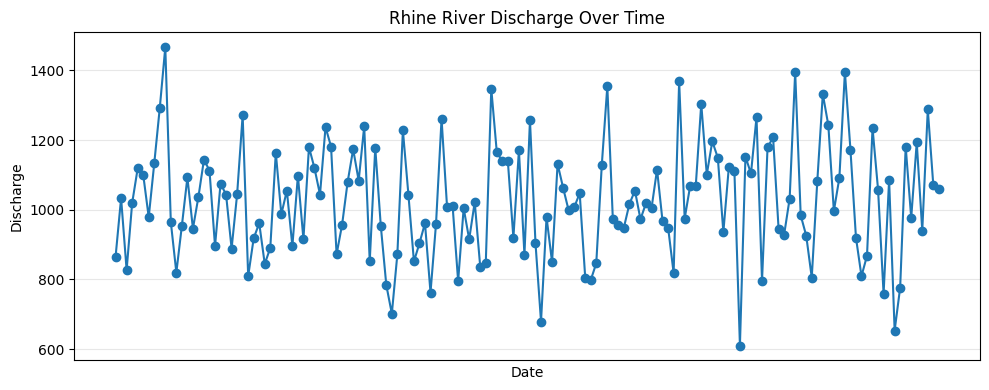


Attempting seasonal decomposition with period=50 (small-sample mode).


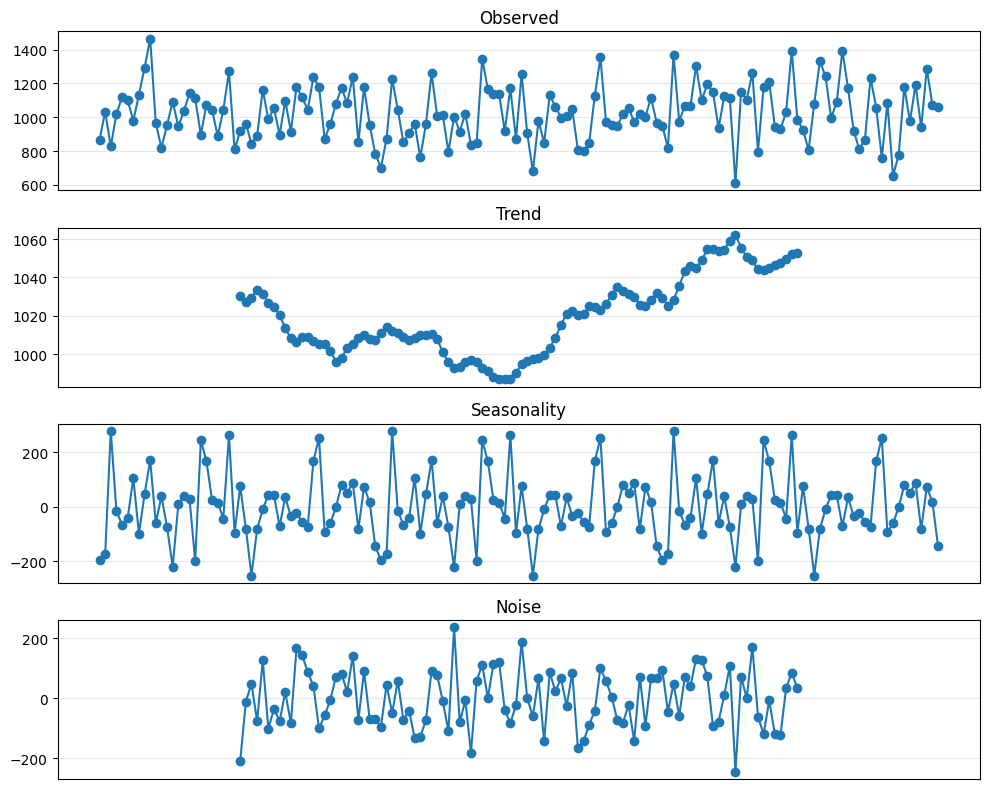

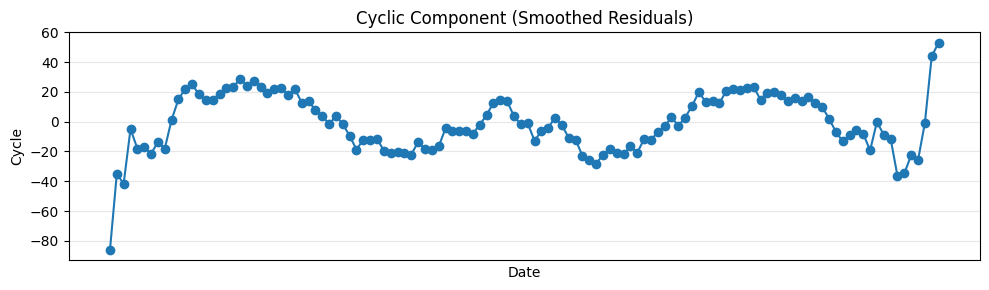


ADF Test on ORIGINAL Rhine Discharge Series
ADF Statistic : -11.267733514756761
p-value       : 1.5643075750689002e-20
# Lags Used   : 0
# Observations: 149
Critical Values:
   1%: -3.4750180242954167
   5%: -2.8811408028842043
   10%: -2.577221358046935
Conclusion: p-value <= 0.05 → reject H0 → series is LIKELY STATIONARY.

Train period: 1970-01-01 00:00:00.000001807 to 1970-01-01 00:00:00.000001911
Test period : 1970-01-01 00:00:00.000001912 to 1970-01-01 00:00:00.000001956
Train size: 105  | Test size: 45

Fitting ARIMA(1, 1, 1) model on TRAIN data...

Model fitted. Short summary:


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Discharge   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -671.631
Date:                Tue, 18 Nov 2025   AIC                           1349.263
Time:                        20:02:34   BIC                           1357.196
Sample:                    01-01-1970   HQIC                          1352.477
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1053      0.106      0.998      0.318      -0.102       0.312
ma.L1         -0.9997      2.501     -0.400      0.689      -5.902       3.903
sigma2      2.277e+04   5.83e+04      0.391      0.6

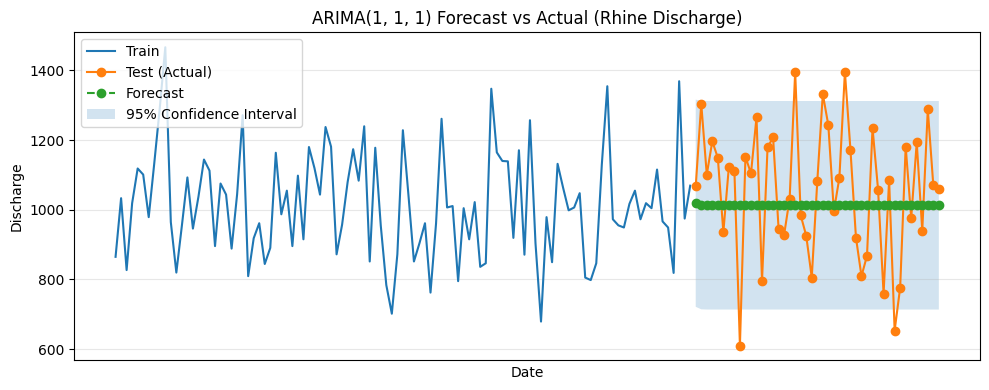


Forecast Accuracy on TEST set:
RMSE: 189.30
MAE : 157.63


In [7]:
# ============================================================
# SMALL DATASET TIME SERIES ANALYSIS
# Dataset: rhine_river_discharge.csv
#
# This script is robust for SMALL datasets:
#   - Always: load, clean, basic plot
#   - If n >= 6 and not constant: seasonal decomposition (simple period)
#   - If n >= 5 and not constant: ADF stationarity test
#   - If n >= 10 and not constant: train/test split, ARIMA, forecast
# ============================================================

# ---- IMPORT LIBRARIES ----
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ---- Helper to clean and rotate x-axis labels everywhere ----
def clean_xaxis(ax, angle=60):
    """
    Makes x-axis readable:
    - yearly ticks (if dates span > 1 year)
    - rotated labels
    - right-aligned
    """
    try:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    except Exception:
        pass
    plt.setp(ax.get_xticklabels(),
             rotation=angle,
             ha='right',
             fontsize=9)


# ============================================================
# STEP 1: LOAD THE DATA AND DETECT COLUMNS
# ============================================================

# Read the CSV file
df = pd.read_csv("rhine_river_discharge.csv")

print("Columns in file:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# --- Detect DATE column ---
date_col = None

# 1) Prefer columns whose name looks like date/time
for col in df.columns:
    if "date" in col.lower() or "time" in col.lower():
        date_col = col
        break

# 2) If not found, try to detect by content (strings with '-' or '/')
if date_col is None:
    for col in df.columns:
        if df[col].dtype == object and df[col].astype(str).str.contains("-|/").any():
            date_col = col
            break

# 3) If still not found, just use the first column
if date_col is None:
    date_col = df.columns[0]

print(f"\nDetected date column: {date_col}")

# Convert to datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Drop rows where date could not be parsed
df = df.dropna(subset=[date_col])

# --- Detect DISCHARGE / VALUE column (numeric) ---
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found for discharge/value.")

# If there are multiple numeric columns, try to pick one with a nice name
value_col = numeric_cols[0]
for candidate in numeric_cols:
    if any(word in candidate.lower() for word in ["discharge", "flow", "q", "value", "level", "runoff"]):
        value_col = candidate
        break

print(f"Detected discharge/value column: {value_col}")

# Sort by date and set index
df = df.sort_values(date_col)
df = df.set_index(date_col)

# Build the time series (NO asfreq – keep original dates)
ts = df[value_col].astype(float)

print("\nFirst few values of the time series:")
print(ts.head())

n_obs = len(ts)
n_unique = ts.nunique()
is_constant = (n_unique == 1)

print(f"\nNumber of observations: {n_obs}")
print(f"Number of unique values: {n_unique} (constant={is_constant})")


# ============================================================
# STEP 2: BASIC PLOT OF THE TIME SERIES
# ============================================================

plt.figure(figsize=(10, 4))
plt.plot(ts.index, ts, marker="o", linestyle="-")
plt.title("Rhine River Discharge Over Time")
plt.xlabel("Date")
plt.ylabel(value_col)
plt.grid(True, alpha=0.3)

ax = plt.gca()
clean_xaxis(ax)

plt.tight_layout()
plt.show()

# If only 1 or 2 observations, we stop here.
if n_obs <= 2:
    print("\nDataset is extremely small (<= 2 points).")
    print("We can only plot the data; decomposition, ADF, and ARIMA are not meaningful.")
    # Stop the script gracefully
else:
    # ============================================================
    # STEP 3: SIMPLE SEASONAL DECOMPOSITION (IF POSSIBLE)
    # ============================================================

    if n_obs >= 6 and not is_constant:
        # For tiny series, pick a very small period:
        # e.g., if n=6 → period=2; if n=9 → period=3
        period = max(2, n_obs // 3)
        # Make sure we have at least 2*period points
        if n_obs >= 2 * period:
            print(f"\nAttempting seasonal decomposition with period={period} (small-sample mode).")
            try:
                decomp = seasonal_decompose(ts, model="additive", period=period)

                trend = decomp.trend
                seasonal = decomp.seasonal
                resid = decomp.resid

                # Cyclic component = smoothed residuals
                cycle = resid.rolling(window=max(2, period // 2),
                                      center=True,
                                      min_periods=2).mean()
                noise = resid - cycle

                fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

                axes[0].plot(ts.index, ts, marker="o")
                axes[0].set_title("Observed")
                axes[0].grid(True, alpha=0.3)

                axes[1].plot(trend.index, trend, marker="o")
                axes[1].set_title("Trend")
                axes[1].grid(True, alpha=0.3)

                axes[2].plot(seasonal.index, seasonal, marker="o")
                axes[2].set_title("Seasonality")
                axes[2].grid(True, alpha=0.3)

                axes[3].plot(noise.index, noise, marker="o")
                axes[3].set_title("Noise")
                axes[3].grid(True, alpha=0.3)

                clean_xaxis(axes[3])
                plt.tight_layout()
                plt.show()

                # Cyclic component plot
                plt.figure(figsize=(10, 3))
                plt.plot(cycle.index, cycle, marker="o")
                plt.title("Cyclic Component (Smoothed Residuals)")
                plt.xlabel("Date")
                plt.ylabel("Cycle")
                plt.grid(True, alpha=0.3)
                ax = plt.gca()
                clean_xaxis(ax)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"\nSeasonal decomposition failed (small dataset): {e}")
        else:
            print(f"\nNot enough data for 2 cycles (need >= {2*period}, have {n_obs}).")
            print("Skipping seasonal decomposition.")
    else:
        print("\nNot attempting decomposition (too few points or constant series).")

    # ============================================================
    # STEP 4: ADF (AUGMENTED DICKEY-FULLER) TEST (IF POSSIBLE)
    # ============================================================

    def run_adf_test(series, title):
        """
        Runs the ADF test on a time series and prints an easy summary.
        Handles the 'x is constant' / tiny series error gracefully.
        """
        print("\n" + "="*60)
        print(title)
        print("="*60)

        series = series.dropna()

        if len(series) < 5:
            print(f"Too few points for ADF test (need ~5+, have {len(series)}). Skipping.")
            return

        try:
            result = adfuller(series)
        except ValueError as e:
            print(f"ADF test could not be run: {e}")
            return

        adf_stat = result[0]
        p_value = result[1]
        used_lags = result[2]
        n_obs_local = result[3]
        critical_values = result[4]

        print(f"ADF Statistic : {adf_stat}")
        print(f"p-value       : {p_value}")
        print(f"# Lags Used   : {used_lags}")
        print(f"# Observations: {n_obs_local}")

        print("Critical Values:")
        for key, value in critical_values.items():
            print(f"   {key}: {value}")

        if p_value <= 0.05:
            print("Conclusion: p-value <= 0.05 → reject H0 → series is LIKELY STATIONARY.")
        else:
            print("Conclusion: p-value > 0.05 → fail to reject H0 → series is LIKELY NON-STATIONARY.")

    if not is_constant:
        run_adf_test(ts, "ADF Test on ORIGINAL Rhine Discharge Series")
    else:
        print("\nSeries is constant → ADF test not meaningful.")

    # ============================================================
    # STEP 5: TRAIN / TEST SPLIT + ARIMA (IF POSSIBLE)
    # ============================================================

    if (n_obs >= 10) and (not is_constant):
        # Simple 70/30 split, but ensure at least 5 points in each
        train_size = max(5, int(n_obs * 0.7))
        test_size = n_obs - train_size
        if test_size < 3:
            test_size = 3
            train_size = n_obs - test_size

        train = ts.iloc[:train_size]
        test = ts.iloc[train_size:]

        print("\nTrain period:", train.index.min(), "to", train.index.max())
        print("Test period :", test.index.min(), "to", test.index.max())
        print("Train size:", len(train), " | Test size:", len(test))

        # ---- Fit ARIMA ----
        model_order = (1, 1, 1)
        print(f"\nFitting ARIMA{model_order} model on TRAIN data...")

        try:
            arima_model = ARIMA(train, order=model_order)
            arima_result = arima_model.fit()
            print("\nModel fitted. Short summary:")
            print(arima_result.summary())
        except Exception as e:
            print(f"\nARIMA model could not be fitted on this small dataset: {e}")
            arima_result = None

        if arima_result is not None:
            # ---- Forecast on test period ----
            n_test = len(test)
            forecast_obj = arima_result.get_forecast(steps=n_test)
            forecast_mean = forecast_obj.predicted_mean
            forecast_ci = forecast_obj.conf_int()

            # Align forecast index with test index
            forecast_mean.index = test.index
            forecast_ci.index = test.index

            plt.figure(figsize=(10, 4))
            plt.plot(train.index, train, label="Train")
            plt.plot(test.index, test, marker="o", label="Test (Actual)")
            plt.plot(forecast_mean.index, forecast_mean, marker="o", linestyle="--",
                     label="Forecast")

            plt.fill_between(
                forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                alpha=0.2,
                label="95% Confidence Interval"
            )

            plt.title(f"ARIMA{model_order} Forecast vs Actual (Rhine Discharge)")
            plt.xlabel("Date")
            plt.ylabel(value_col)
            plt.legend()
            plt.grid(True, alpha=0.3)

            ax = plt.gca()
            clean_xaxis(ax)

            plt.tight_layout()
            plt.show()

            # ---- Forecast accuracy ----
            rmse = sqrt(mean_squared_error(test, forecast_mean))
            mae = mean_absolute_error(test, forecast_mean)

            print("\nForecast Accuracy on TEST set:")
            print(f"RMSE: {rmse:,.2f}")
            print(f"MAE : {mae:,.2f}")
    else:
        print("\nNot enough data for ARIMA (need ~10+ non-constant points). Skipping modeling.")
